## Importación de librerías

En esta celda se importan las librerías necesarias para el análisis y el procesamiento de datos, así como las herramientas para la creación y evaluación de modelos de Machine Learning.

- `pandas`: Para la manipulación y análisis de datos, especialmente con DataFrames.
- `seaborn`: Para la visualización de datos estadísticos.
- `matplotlib.pyplot`: Para crear gráficos y visualizaciones.
- `BeautifulSoup`: Para la extracción de datos de HTML (web scraping).
- `re`: Para trabajar con expresiones regulares, útil en la limpieza de datos.
- `nltk`: Natural Language Toolkit, para el procesamiento y análisis de texto.
- `stopwords` de `nltk`: Para eliminar palabras comunes que no aportan significado (como "y", "de", "la", etc.).
- `TfidfVectorizer`: Para la vectorización de texto mediante el cálculo de la frecuencia de términos.
- `hstack` de `scipy.sparse`: Para combinar matrices dispersas.
- `string`: Para manipular cadenas de texto.
- `train_test_split` de `sklearn.model_selection`: Para dividir el conjunto de datos en entrenamiento y prueba.
- `XGBClassifier` de `xgboost`: Para el clasificador de árboles de decisión basado en el algoritmo XGBoost.
- `classification_report` y `confusion_matrix` de `sklearn.metrics`: Para evaluar el rendimiento del modelo con métricas como precisión, recall y f1-score, además de la matriz de confusión.

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import string
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Análisis exploratorio de datos

En este apartado se cargan los conjuntos de datos que se utilizarán para el análisis. Los datos provienen de dos fuentes diferentes:

1. **Dataset de Phishing:** 
   - Se carga el archivo `CEAS_08.csv`, que contiene un conjunto de datos de correos electrónicos relacionados con phishing. Este conjunto de datos se obtiene de Kaggle: [Phishing Email Dataset](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset/data).
   
2. **Dataset de Spam:**
   - Se carga el archivo `combined_data.csv`, que contiene un conjunto de datos de correos electrónicos clasificados como spam o no spam. Este conjunto de datos proviene de Kaggle: [Email Spam Classification Dataset](https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset).

Ambos archivos se cargan en objetos `DataFrame` de `pandas` para su posterior procesamiento y análisis.

En ambos conjuntos de datos, la columna **`label`** indica si el correo es **Ham (0)**, es decir, no peligroso, o **Spam/Phishing (1)** según corresponda en cada dataset.

In [40]:
#https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset/data
phishing_data = pd.read_csv('../datasets/CEAS_08.csv')
#https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset
spam_data = pd.read_csv('../datasets/combined_data.csv')

En esta celda se genera una gráfica de barras que compara la cantidad de elementos etiquetados como `label 1` en los datasets de **Phishing** y **Spam**. 

- **Phishing Data:** Corresponde a los correos electrónicos relacionados con el phishing, donde `label 1` indica correos phishing.
- **Spam Data:** Corresponde a los correos electrónicos clasificados como spam, donde `label 1` indica correos spam.

La gráfica muestra la cantidad de registros etiquetados como `label 1` en cada uno de los datasets, lo que permite visualizar y comparar la prevalencia de correos considerados peligrosos (Phishing/Spam) en cada conjunto de datos.

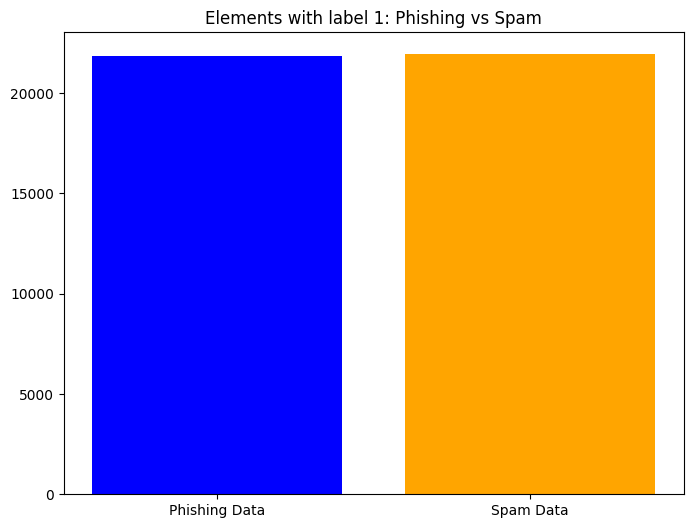

In [41]:
# Contar la cantidad de label 1 en cada dataset
phishing_label_1_count = phishing_data[phishing_data['label'] == 1].shape[0]
spam_label_1_count = spam_data[spam_data['label'] == 1].shape[0]

# Crear una lista con los nombres de los datasets y sus respectivas cantidades de label 1
datasets = ['Phishing Data', 'Spam Data']
label_1_counts = [phishing_label_1_count, spam_label_1_count]

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.bar(datasets, label_1_counts, color=['blue', 'orange'])

# Añadir etiquetas y título
plt.title('Elements with label 1: Phishing vs Spam')

# Mostrar la gráfica
plt.show()

Se imprimen las columnas de ambos conjuntos de datos para tener una visión general de las características disponibles en cada uno.

In [42]:
print(phishing_data.columns)
print(spam_data.columns)

Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls'], dtype='object')
Index(['label', 'text'], dtype='object')


1. Se crea una nueva columna en el conjunto de datos de phishing que combina las columnas 'subject' y 'body' en una sola columna 'text'.
2. Se eliminan las columnas innecesarias en `phishing_data` como 'sender', 'receiver', 'date', 'subject', 'body' y 'urls'.
3. En `spam_data`, se seleccionan solo las columnas 'label' y 'text'.
4. Se reemplaza el valor '1' en la columna 'label' por '2' para modificar las clases del dataset de spam.

In [43]:
# 1
phishing_data['text'] = phishing_data['subject'].fillna('') + ' ' + phishing_data['body'].fillna('')
# 2
phishing_data = phishing_data.drop(columns=['sender', 'receiver', 'date', 'subject', 'body', 'urls'])
# 3
spam_data = spam_data[['label', 'text' ]]
# 4
spam_data['label'] = spam_data['label'].replace(1,2)

In [44]:
print(phishing_data.columns)
print(spam_data.columns)

Index(['label', 'text'], dtype='object')
Index(['label', 'text'], dtype='object')


Ahora estudiemos la cantidad de datos etiquetados como 'Ham' en comparación con los demás datos

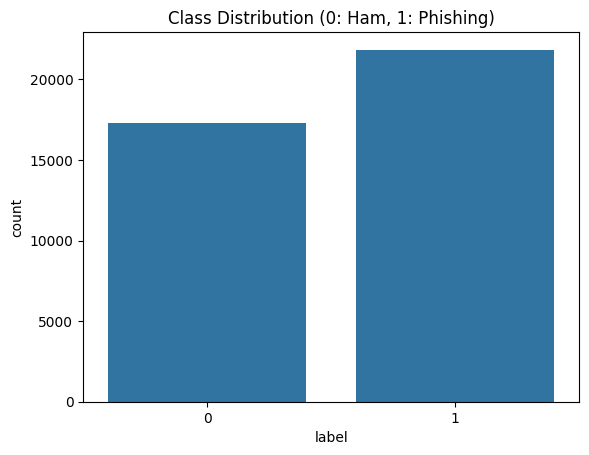

In [45]:
sns.countplot(x='label', data=phishing_data)
plt.title("Class Distribution (0: Ham, 1: Phishing)")
plt.show()

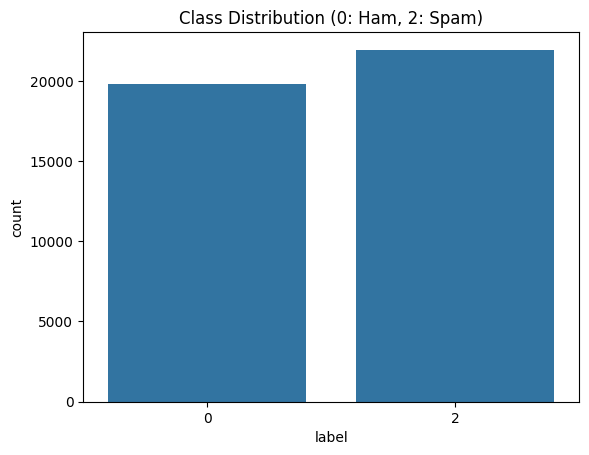

In [46]:
spam_data.head(5)
sns.countplot(x='label', data=spam_data)
plt.title("Class Distribution (0: Ham, 2: Spam)")
plt.show()

En esta celda se combinan los datasets de **Phishing** y **Spam** utilizando la función `pd.concat`. Los dos conjuntos de datos se concatenan de forma vertical (por filas) y se reinicia el índice para que sea único en el nuevo `DataFrame` resultante, `mail_data`. 


In [47]:
mail_data = pd.concat([phishing_data, spam_data], ignore_index=True)
mail_data.info
phishing_data

,label,text
0,1,"Never agree to be a loser Buck up, your troubl..."
1,1,Befriend Jenna Jameson \nUpgrade your sex and ...
2,1,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3,0,Re: svn commit: r619753 - in /spamassassin/tru...
4,1,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...
...,...,...
39151,0,Slideshow viewer Hello there ! \nGreat work on...
39152,0,"Note on 2-digit years \nMail from sender , com..."
39153,0,[Python-Dev] PEP 370 heads up Dear fellow Pyth...
39154,1,"hello, we attach a list of staff and universi..."


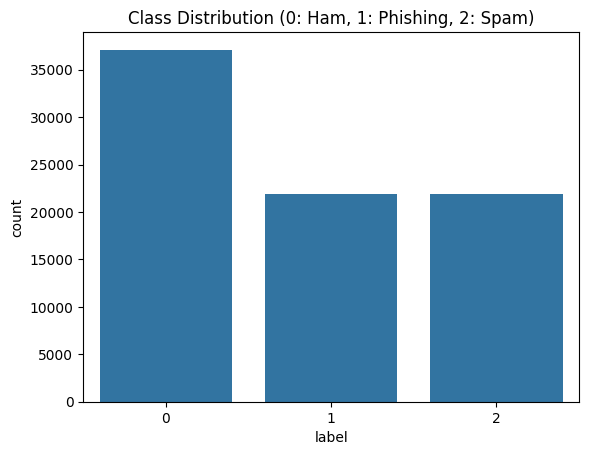

In [14]:
sns.countplot(x='label', data=mail_data)
plt.title("Class Distribution (0: Ham, 1: Phishing, 2: Spam)")
plt.show()

En esta celda se realizan dos operaciones clave para preparar los conjuntos de datos para el entrenamiento:

1. **Modificación de las etiquetas en `mail_data`:**
   - Se reemplazan las etiquetas `2` en el conjunto de datos `mail_data` por `1`. Esto es porque en el conjunto de datos original, la etiqueta `2` representa un correo como **Spam**, pero se necesita que en `mail_data` sólo haya dos categorías: **Ham (0)** y **Spam (1)**. Esta modificación prepara `mail_data` para ser entrenado con la tarea de clasificar un correo entre **ham** (no peligroso) y **spam** (peligroso).

2. **Creación del conjunto de datos `malicious_data`:**
   - Se combina `spam_data` y `phishing_data` en un nuevo `DataFrame` llamado `malicious_data`. Este conjunto de datos se utiliza para distinguir entre **spam inofensivo** (etiquetado como `0`) y **phishing** (etiquetado como `1`).
   - Primero, se filtra el conjunto para eliminar los correos clasificados como **ham** (`label == 0`), ya que solo se quiere trabajar con correos que están etiquetados como spam o phishing.
   - Posteriormente, las etiquetas `2` (representando spam) se reemplazan por `0` para distinguir entre **spam inofensivo (0)** y **phishing (1)**, de acuerdo con la nueva clasificación.

Ambos conjuntos, `mail_data` y `malicious_data`, serán utilizados para entrenar modelos de clasificación en diferentes tareas: el primero para clasificar **ham** y **spam**, y el segundo para identificar si un correo spam es **inofensivo** o **phishing**.

In [15]:
#1
mail_data['label'] = mail_data['label'].replace(2, 1)

#2
malicious_data = pd.concat([spam_data, phishing_data], ignore_index=True)
malicious_data = malicious_data[malicious_data['label'] != 0]
malicious_data['label'] = malicious_data['label'].replace(2, 0)

malicious_data

,label,text
2,0,dear customer it's not a secret that there are...
4,0,person see good not clean it crime on example ...
6,0,hot alert special situation alert tmxo trimax ...
8,0,escapelong escapelong escapelong escapelong es...
9,0,direct encrypted link del escapelong message i...
...,...,...
80869,1,Be larger than ever after 2 months The cure fo...
80870,1,CNN Alerts: My Custom Alert \n\n\nCNN Alerts: ...
80872,1,Patients can access Our online health shop is ...
80873,1,CNN Alerts: My Custom Alert \n\nCNN Alerts: My...


## Preprocesado de los datos

### Funciones de preprocesado de datos para el modelo 1

#### Funcion `limpiar_html`
Esta función tiene como objetivo limpiar un texto que contiene etiquetas HTML y caracteres no deseados:

1. **Eliminar etiquetas HTML:**
   - Se utiliza `BeautifulSoup` para parsear el texto y extraer solo el contenido textual. `BeautifulSoup` convierte cualquier etiqueta HTML en texto sin formato, eliminando así cualquier código HTML como `<html>`, `<body>`, etc.

2. **Eliminar caracteres no alfabéticos:**
   - Luego, se usa una expresión regular (`re.sub`) para eliminar todos los caracteres que no sean letras (mayúsculas o minúsculas) ni espacios. Esto ayuda a limpiar el texto de caracteres especiales, números y otros símbolos no deseados.

In [16]:
def limpiar_html(texto):
    # 1
    texto_sin_html = BeautifulSoup(texto, "html.parser").get_text()
    # 2
    texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto_sin_html)
    return texto_limpio

#### Función `eliminar_stopwords`

Esta función elimina las **palabras de parada** (stopwords) de un texto.

1. **Divide el texto en tokens** (palabras).
2. **Filtra las palabras** que están en la lista de stopwords en inglés proporcionada por `nltk`.
3. **Devuelve el texto** con las palabras de parada eliminadas.

Es útil para enfocar el análisis solo en las palabras relevantes.

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  

def eliminar_stopwords(texto):
    # 1
    tokens = texto.split()
    # 2
    tokens_filtrados = [word for word in tokens if word not in stop_words]
    # 3
    return " ".join(tokens_filtrados)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Función `preprocess_text`

Esta función realiza un **preprocesamiento completo** del texto:

1. **Eliminar etiquetas HTML** usando `limpiar_html`.
2. Convierte todo el texto a **minúsculas**.
3. Elimina las **URLs** y direcciones **email** con expresiones regulares.
4. Elimina los **números** y la **punctuación**.
5. Elimina **espacios en blanco adicionales** con `strip()`.
6. **Elimina las stopwords** utilizando la función `eliminar_stopwords`.

Este proceso limpia y prepara los textos para un análisis posterior.

La columna `clean_text` en el DataFrame `mail_data` contiene el texto preprocesado.

In [18]:
def preprocess_text(text):
    #1
    text = limpiar_html(text) 
    #2
    text = text.lower()
    #3
    text = re.sub(r"http\S+", "", text)                
    text = re.sub(r"\S+@\S+", "", text) 
    #4                   
    text = re.sub(r"\d+", "", text)                         
    text = text.translate(str.maketrans('', '', string.punctuation))  
    #5
    text = text.strip()
    #6
    text = eliminar_stopwords(text) 
    return text

mail_data['clean_text'] = mail_data['text'].astype(str).apply(preprocess_text)

### Funciones de preprocesado de datos para el modelo 2

#### Función `light_clean`

Esta función realiza una limpieza ligera del texto:

1. **Verifica si el texto es una cadena** antes de aplicar el procesamiento.
2. **Elimina espacios en blanco consecutivos** y los reemplaza por un único espacio para finalmente convertir todo a minuscula.
3. Si el input **no es una cadena de caracteres**, la función devuelve una cadena vacía.



In [19]:
def light_clean(text):
    # 1
    if isinstance(text, str):
        # 2
        return re.sub(r'\s+', ' ', text).strip().lower()
    # 3
    return ''  # Si no es una cadena, devolver una cadena vacía 

malicious_data['text'] = malicious_data['text'].apply(light_clean)

#### Función `extract_features`

Esta función extrae características relevantes de un texto para determinar si un correo es potencialmente de **phishing**. Las características extraídas incluyen:

1. **`num_links`:** Cuenta la cantidad de enlaces en el texto. Se detectan enlaces que comienzan con "http", "www", "bit.ly", "tinyurl" o "chk.me".
2. **`has_form`:** Indica si el texto contiene un formulario HTML (buscando etiquetas `<form>` o `input type`).
3. **`has_attachment`:** Señala si el texto menciona archivos adjuntos, como ".zip" o ".exe", o contiene la palabra "attachment".
4. **`text_length`:** Longitud del texto en caracteres.
5. **`num_phishing_keywords`:** Cuenta la cantidad de palabras clave relacionadas con phishing presentes en el texto. Se busca en el texto si contiene alguna de las palabras definidas en la lista `phishing_keywords`.

Estas características son útiles para evaluar el riesgo de que un correo sea malicioso, como un ataque de phishing.

In [20]:
phishing_keywords = [
    # Seguridad y cuenta
    "account", "password", "verify", "login", "update", "security",
    "credentials", "unauthorized", "suspended", "compromised", "alert", "reset",

    # Urgencia o amenaza
    "urgent", "immediately", "action required", "important", "now",
    "verify immediately", "failure", "final warning", "attention", "limited time", "response needed",

    # Recompensas, dinero o premios
    "winner", "congratulations", "free", "bonus", "refund", "claim",
    "reward", "lottery", "prize", "gift card", "cash",

    # Enlaces o descargas
    "click here", "download", "open attachment", "access", "view",
    "see details", "login link", "check now", "follow the link",

    # Entidades suplantadas
    "paypal", "apple", "amazon", "bank", "netflix", "support",
    "help desk", "it department", "administrator", "system", "cnn"
]

def extract_features(text):
    text_lower = text.lower()
    return {
        # 1
        'num_links': len(re.findall(r'http[s]?://|www\.|bit\.ly|tinyurl|chk\.me', text_lower)),
        # 2
        'has_form': int(bool(re.search(r'<form|input type=', text_lower))),
        # 3
        'has_attachment': int('.zip' in text_lower or '.exe' in text_lower or 'attachment' in text_lower),
        # 4
        'text_length': len(text),
        # 5
        'num_phishing_keywords': sum(1 for kw in phishing_keywords if kw in text_lower),
    }

feature_data = malicious_data['text'].apply(extract_features).apply(pd.Series)


### Vectorizado de datos y division en subconjuntos

El **vectorizado de datos** es el proceso de convertir información en formato de texto o datos no estructurados en representaciones numéricas que puedan ser procesadas por algoritmos de machine learning. Esto es necesario porque los modelos de machine learning no pueden trabajar directamente con texto o datos no estructurados.

Existen varias técnicas de vectorización, pero en este caso usaremos:

- **TF-IDF (Term Frequency - Inverse Document Frequency):** Mide la importancia de una palabra en un documento, ponderando las palabras frecuentes en un documento pero raras en el conjunto de datos general.

El vectorizado de datos es fundamental para que los modelos de machine learning puedan analizar y extraer patrones de los datos de manera efectiva.

Luego, sobre cada conjunto de datos `X` (características) y de etiquetas `y`, dividimos en dos subconjuntos: uno para entrenamiento y otro para prueba. 

El resultado de esta operación son cuatro conjuntos:
- `X_train` y `y_train`: Conjuntos para entrenar el modelo.
- `X_test` y `y_test`: Conjuntos para evaluar el rendimiento del modelo después del entrenamiento.

#### Vectorizado y division en subconjuntos del dataset `mail_data` para el modelo 1

In [21]:
# Vectorizado y creación de los conjuntos de entrada y salida
vectorizer = TfidfVectorizer(max_features=7500)  
X = vectorizer.fit_transform(mail_data['clean_text'])
y = mail_data['label']  

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#### Vectorizado y division en subconjuntos del dataset `malicious_data` para el modelo 2

In [22]:
# Vectorizado y creación de los conjuntos de entrada y salida
vectorizer2 = TfidfVectorizer(max_features=5000, stop_words='english')
X_malicious_text = vectorizer2.fit_transform(malicious_data['text'])
y_malicious = malicious_data['label']  

# Combinar dos conjuntos de características en un solo conjunto
X_malicious_combined = hstack([X_malicious_text, feature_data])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_malicious_train, X_malicious_test, y_malicious_train, y_malicious_test = train_test_split(X_malicious_combined, y_malicious, test_size=0.2, random_state=42, stratify=y_malicious)


## Entrenamiento, predicción y evaluación de los modelos

### Entrenamiento y Evaluación de los Modelos

En esta celda se entrenan y evalúan dos modelos de clasificación utilizando el algoritmo XGBoost (`XGBClassifier`):

1. **Modelo Spam vs Ham:**
   - El primer modelo (`model`) es entrenado utilizando el conjunto de datos `X_train` (características de los correos) y `y_train` (etiquetas Spam/Ham).
   - Después del entrenamiento, se realiza la predicción sobre el conjunto de prueba `X_test` y se imprime el informe de clasificación (`classification_report`), que muestra métricas como precisión, recall y F1-score.

2. **Modelo Spam vs Phishing:**
   - El segundo modelo (`malicious_model`) se entrena utilizando un conjunto de datos modificado (`X_malicious_train` y `y_malicious_train`), donde se distinguen correos etiquetados como spam inofensivo y phishing.
   - Tras el entrenamiento, se evalúa su rendimiento utilizando `X_malicious_test` y se imprime el informe de clasificación correspondiente.

El parámetro `eval_metric='mlogloss'` en ambos modelos especifica que la métrica utilizada para evaluar el rendimiento durante el entrenamiento sea el logaritmo de la pérdida multinomial (log loss)

In [23]:
# 1
model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

print("Spam vs Ham Classification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


# 2
malicious_model = XGBClassifier(eval_metric='mlogloss')
malicious_model.fit(X_malicious_train, y_malicious_train)

print("Spam vs Phishing Classification Report:")
y_pred_malicious = malicious_model.predict(X_malicious_test)
print(classification_report(y_malicious_test, y_pred_malicious))

Spam vs Ham Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7420
           1       0.97      0.99      0.98      8756

    accuracy                           0.97     16176
   macro avg       0.98      0.97      0.97     16176
weighted avg       0.97      0.97      0.97     16176

Spam vs Phishing Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4388
           1       0.99      0.98      0.99      4369

    accuracy                           0.99      8757
   macro avg       0.99      0.99      0.99      8757
weighted avg       0.99      0.99      0.99      8757



### Matriz de confusion para cada modelo


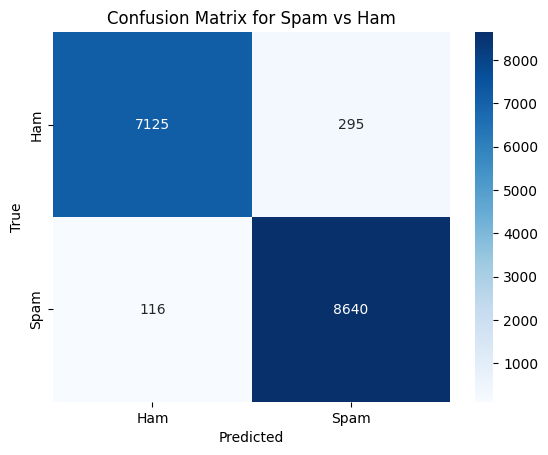

In [24]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam' ])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Spam vs Ham")
plt.show()

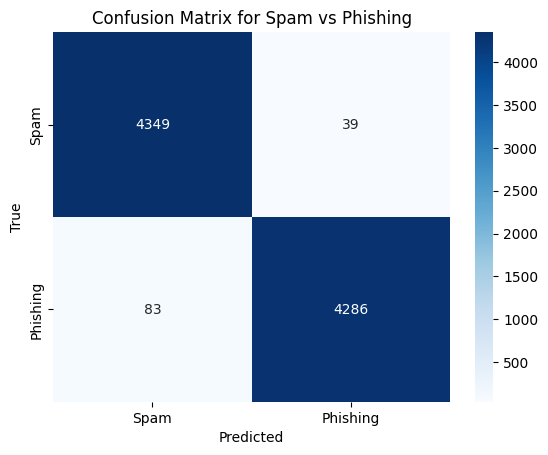

In [25]:
cm_malicious = confusion_matrix(y_malicious_test, y_pred_malicious)
sns.heatmap(cm_malicious, annot=True, fmt='d', cmap='Blues', xticklabels=['Spam', 'Phishing'], yticklabels=['Spam', 'Phishing' ])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Spam vs Phishing")
plt.show()

## Ejemplo de salida

In [26]:
def preprocess_email(text):
    clean = preprocess_text(text) 
    return vectorizer.transform([clean])

In [27]:


# Suponiendo que tienes un correo de entrada para predecir
new_email = '''Re: (Funds available) Application accepted Hello,

Our university support team has offered you 650 euros to help finance your studies...
You can access it by clicking: *https://financiaci=C3=B3n-ugr-es/consultar
<https://chk.me/SE1wIGD>*

Administraci=C3=B3n.
*AINHARA GONZALEZ*
'''
vec = preprocess_email(new_email) 
# Realizamos la predicción de probabilidades usando predict_proba


# Predicción con el modelo YA ENTRENADO
probabilities = model.predict_proba(vec)

# Probabilidades por clase
class_names = ['Ham', 'Spam']  # Nombres de las clases

# Mostrar las probabilidades en porcentaje
probabilities_percent = probabilities[0] * 100  # Convertimos a porcentaje
for class_name, prob in zip(class_names, probabilities_percent):
    print(f"{class_name}: {prob:.2f}%")

# Si la probabilidad de Spam supera el 50%, aplicar modelo de phishing
spam_prob = probabilities[0][1]  # índice 1 corresponde a Spam
if spam_prob > 0.5:
    print("\nSpam detectado. Analizando si es phishing o spam inofensivo...\n")

    # Extraemos manual features 
    new_email = light_clean(new_email)  
    features = extract_features(new_email)  # función que creas tú
    feature_values = list(features.values())
    vec_malicious = vectorizer2.transform([new_email])  # TF-IDF o similar
    full_features = hstack([vec_malicious, feature_values])  # combinar TF-IDF + manual features

    # Aplicar el modelo especializado
    phishing_probs = malicious_model.predict_proba(full_features)[0]
    labels = ['Spam inofensivo', 'Phishing']
    for label, prob in zip(labels, phishing_probs):
        print(f"{label}: {prob*100:.2f}%")
    
    # Mensaje resumen
    if phishing_probs[1] > 0.5:
        print("\n⚠️ Alerta: Este mensaje podría ser phishing.")
    else:
        print("\n✅ Clasificado como spam inofensivo.")

Ham: 18.78%
Spam: 81.22%

Spam detectado. Analizando si es phishing o spam inofensivo...

Spam inofensivo: 0.15%
Phishing: 99.85%

⚠️ Alerta: Este mensaje podría ser phishing.
